This notebook attempts to use a plane-fit approach for finding the nearest grid point.
Eg, we have a function for each grid index as functions of lon, lat.
The results are approximate! But they help restrict significantly the followup searching.

In [1]:
%matplotlib notebook
import numpy as np
import netCDF4 as nc
from salishsea_tools.geo_tools import find_closest_model_point
import scipy.linalg
import matplotlib.pyplot as plt

In [2]:
with nc.Dataset('/home/mdunphy/MEOPAR/NEMO-forcing/grid/coordinates_seagrid_SalishSea201702.nc') as nbl:
#with nc.Dataset('/home/mdunphy/MEOPAR/NEMO-forcing/grid/coordinates_seagrid_SalishSea.nc') as nbl:
    glamt = nbl.variables['glamt'][0,...]
    gphit = nbl.variables['gphit'][0,...]

ONES, X, Y = np.ones(glamt.size), glamt.flatten(), gphit.flatten()

idx = np.indices(glamt.shape)
datai = idx[1,...].flatten()
dataj = idx[0,...].flatten()

In [3]:
def getC(X,Y,data,order):
    if order == 1:
        # best-fit linear plane
        A = np.c_[ONES,
                  X, Y]
    elif order == 2:
        # best-fit quadratic curve
        A = np.c_[ONES,
                  X, Y,
                  X**2, X*Y, Y**2]
    elif order == 3:
        # best-fit cubic curve
        A = np.c_[ONES,
                  X, Y,
                  X**2, X*Y, Y**2,
                  X**3, X*X*Y, X*Y*Y, Y**3]
    elif order == 4:
        # best-fit quartic curve
        A = np.c_[ONES,
                  X, Y,
                  X**2, X*Y, Y**2,
                  X**3, X*X*Y, X*Y*Y, Y**3,
                  X**4, X*X*X*Y, X*X*Y*Y, X*Y*Y*Y, Y**4]
    elif order == 5:
        # best-fit quintic curve
        A = np.c_[ONES,
                  X, Y,
                  X**2, X*Y, Y**2,
                  X**3, X*X*Y, X*Y*Y, Y**3,
                  X**4, X*X*X*Y, X*X*Y*Y, X*Y*Y*Y, Y**4,
                  X**5, X*X*X*X*Y, X*X*X*Y*Y, X*X*Y*Y*Y, X*Y*Y*Y*Y, Y**5]

    C,_,_,_ = scipy.linalg.lstsq(A, data)    # coefficients
    return C

def useC(X,Y,C):
    if C.size >= 3:
        R = C[0] + C[1]*X + C[2]*Y
    if C.size >= 6:
        R += C[3]*X**2 + C[4]*X*Y + C[5]*Y**2
    if C.size >= 10:
        R += C[6]*X**3 + C[7]*X*X*Y + C[8]*X*Y*Y  + C[9]*Y**3
    if C.size >= 15:
        R += C[10]*X**4 + C[11]*X*X*X*Y + C[12]*X*X*Y*Y  + C[13]*X*Y*Y*Y + C[14]*Y**4
    if C.size >= 21:
        R += C[15]*X**5 + C[16]*X*X*X*X*Y + C[17]*X*X*X*Y*Y + C[18]*X*X*Y*Y*Y  + C[19]*X*Y*Y*Y*Y + C[20]*Y**5
    return R


In [4]:
# Pick one
order = 2
Ci = getC(X,Y,datai,order)
Cj = getC(X,Y,dataj,order)
print("Ci", Ci)
print("Cj", Cj)

Ci [  1.26921890e+04   1.59279223e+02   1.39650621e+02   3.21769836e-01
   1.37597009e+00   1.58488524e+00]
Cj [ -1.26067300e+04   6.53817493e+00   1.76514195e+02   4.90478919e-01
   9.06976896e-01   1.33030515e+00]


In [5]:
ei = np.max(datai-useC(X,Y,Ci))
ej = np.max(dataj-useC(X,Y,Cj))
print("Max error in i: ", ei, ", suggest search box: +/- ", np.ceil(ei)+1)
print("Max error in j: ", ej, ", suggest search box: +/- ", np.ceil(ej)+1)

Max error in i:  2.55633160165 , suggest search box: +/-  4.0
Max error in j:  17.7487100078 , suggest search box: +/-  19.0


<IPython.core.display.Javascript object>


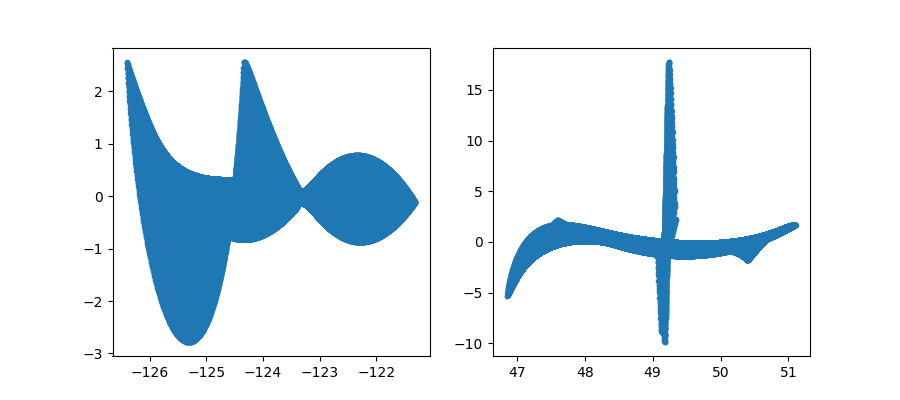

In [6]:
plt.figure(figsize=(9,4)); plt.clf();
plt.subplot(1,2,1); plt.plot(X,datai-useC(X,Y,Ci),'.')
plt.subplot(1,2,2); plt.plot(Y,dataj-useC(X,Y,Cj),'.')